# TP2

- Autores: 
    - Valentín Pertierra
    - Leandro Saraco
- Año 2024

## Consigna

Implementar la función create_gauss_filter (h, w, k_size , para crear filtros gaussianos para
filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada
de Fourier.

1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una imagen para validar el funcionamiento en el dominio espectral.

2. Usando el método descripto en el paper Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.

3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape from focus”.

In [2]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pywt

In [72]:
# Para mostrar imagenes fácilmente y evitar usar cv.imshow que creashea in Windows con VSCode
def imshow(title,img,figsize=(12,8)):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    plt.show()

def imshow_compare(big_title,title1,img1,title2,img2,figsize=(12,5),mode="color"):
    plt.figure(figsize=figsize)
    plt.title(big_title,size=10,fontweight="bold")
    plt.axis("off")
    ax1 = plt.subplot(121)
    ax1.set_title(title1,size=8)
    ax1.imshow(cv.cvtColor(img1,cv.COLOR_BGR2RGB)) if mode=="color" else ax1.imshow(img1,cmap="gray")
    ax1.set_axis_off()
    ax2 = plt.subplot(122)
    ax2.set_title(title2,size=8)
    ax2.imshow(cv.cvtColor(img2,cv.COLOR_BGR2RGB)) if mode =="color" else ax2.imshow(img2,cmap="gray")
    ax2.set_axis_off()
    plt.show()


## Implementación de la funcion create_gauss_filter

In [4]:
def create_gauss_filter(h, w, k_size=5, sigma=5):
    kernel_1d = cv.getGaussianKernel(ksize=k_size, sigma=sigma) 
    kernel = kernel_1d * kernel_1d.T
    m, n = kernel.shape
    if w < m or h < n:
        raise ValueError("El tamaño del kernel no puede ser más grande que el de la imagen")
    #Obtengo centro de la imagen menos mitad del tamaño del kernel
    y, x = (w - m) // 2, (h - n) // 2
    #Creo el filtro todo con ceros y en el centro el kernel
    filter = np.zeros((w, h))
    filter[y:y+m, x:x+n] = kernel
    #Obtengo filtro en el domino frecuencial
    kernel_tf = np.fft.fft2(filter)
    return (kernel,filter,kernel_tf)

Prueba de filtrado espacial comparando con GaussianBlur de openCV

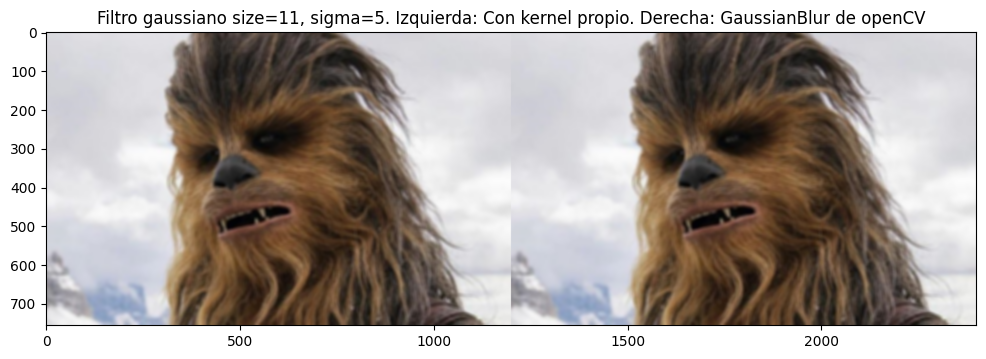

In [5]:
# Cargo imagen y seteo valores
img_orig = cv.imread('chewbacca.jpg')
k_size = 11
sigma = 5

# Creo kernel gaussiano con la función propia
kernel, filter, kernel_tf = create_gauss_filter(img_orig.shape[1],img_orig.shape[0], k_size=k_size, sigma=sigma)
 
# Aplicamos el filtro Gaussiano
img_filtrada_kernel_propio = cv.filter2D(img_orig,  ddepth=-1, kernel=kernel)

# Lo mismo pero hecho todo con openCV, para comparar
img_filtrada_openCV = cv.GaussianBlur(img_orig, ksize=(k_size, k_size), sigmaX=sigma,  sigmaY=sigma)

# Pongo uno al lado del otro
result = cv.hconcat([img_filtrada_kernel_propio,img_filtrada_openCV])




imshow(f"Filtro gaussiano size={k_size}, sigma={sigma}. Izquierda: Con kernel propio. Derecha: GaussianBlur de openCV",result)

Comparación de filtrado espacial con kernel propio y con openCV usando XOR

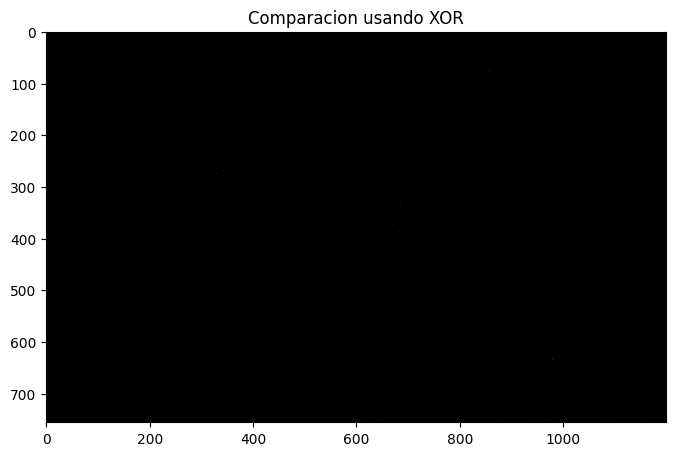

In [6]:
img_compare = cv.bitwise_xor(img_filtrada_kernel_propio,img_filtrada_openCV)
imshow("Comparacion usando XOR",img_compare,figsize=(8,6))

Prueba de filtrado con FFT

In [7]:
def filter_image_FFT(img,kernel,mode="color"):
    # Convierto a float32 para más precision (antes de haber implementado esto se veia en la siguiente celda mucha diferencia en el XOR)
    img = np.float32(img)
    # Aplico FFT solo en las primeras 2 dimensiones (la tercera son los canales B,G,R)
    img_fft = np.fft.fft2(img, axes=(0, 1))
    # Replico el filtro para cada canal
    filtro_stacked = np.stack([kernel]*3, axis=-1) if mode =="color" else kernel
    # Aplico filtro en el dominio frecuencial
    img_filtered_f = img_fft * filtro_stacked
    # Convierto devuelta al dominio espacial usando ifft
    img_filtered = np.fft.ifftshift(np.real(np.fft.ifft2(img_filtered_f, axes=(0, 1))),axes=(0,1))
    # Vuelvo a normalizar todo dentro de 0 y 256 y convierto a uint8
    # img_filtered = cv.normalize(img_filtered, None, 0, 255, cv.NORM_MINMAX)
    img_filtered = np.uint8(img_filtered)
    return img_filtered



Text(0.5, 1.0, 'Imagen filtrada frecuencialmente')

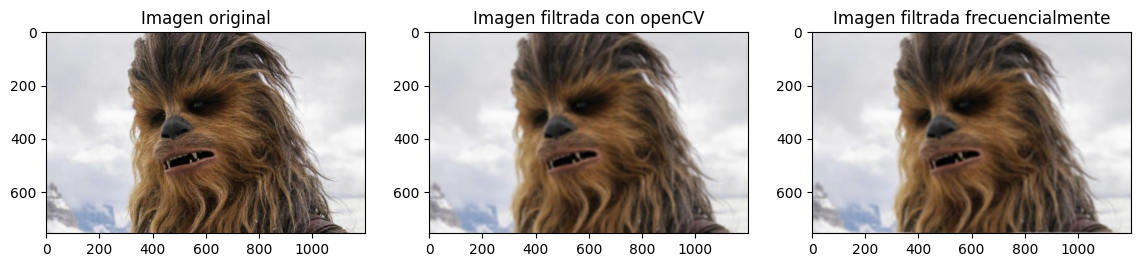

In [8]:
# Leo imagen con openCV
img_bgr = cv.imread('./chewbacca.jpg')

# Filtro usando FFT
imagen_filtrada_frecuencial = filter_image_FFT(img_bgr,kernel_tf)

# Comparo imagenes
plt.figure(figsize=(14,9))

# Imagen original
plt.subplot(131), plt.imshow(cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB))
plt.title('Imagen original')

# Imagen con GaussianBlur de openCV
plt.subplot(132), plt.imshow(cv.cvtColor(img_filtrada_openCV, cv.COLOR_BGR2RGB))
plt.title('Imagen filtrada con openCV')

# Imagen filtrada frecuencialmente
plt.subplot(133), plt.imshow(cv.cvtColor(imagen_filtrada_frecuencial, cv.COLOR_BGR2RGB))
plt.title('Imagen filtrada frecuencialmente')

Comparando filtrado frecuencial con filtrado hecho por GaussianBlur de openCV

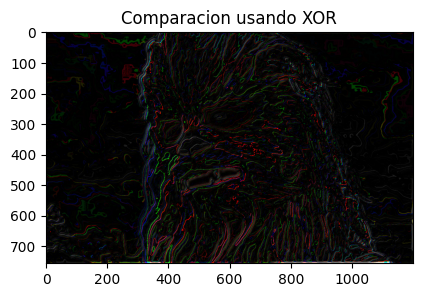

In [9]:
img_compare = cv.bitwise_xor(imagen_filtrada_frecuencial,img_filtrada_openCV)
imshow("Comparacion usando XOR",img_compare,figsize=(5,3))

## 1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma

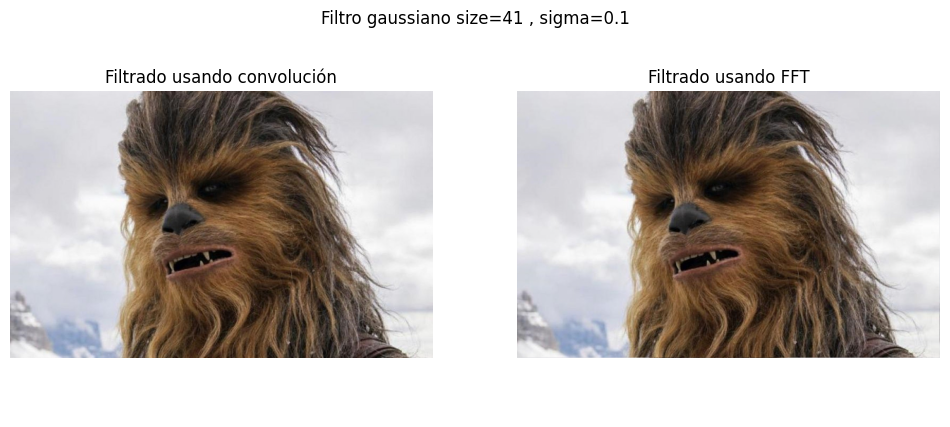

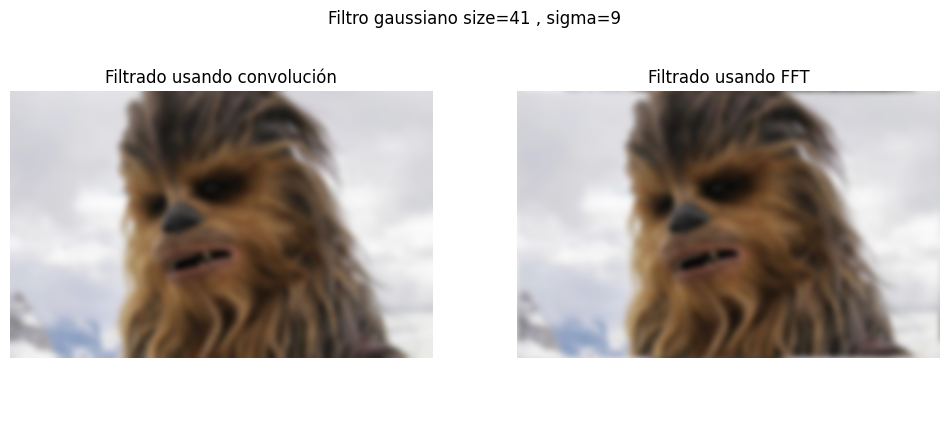

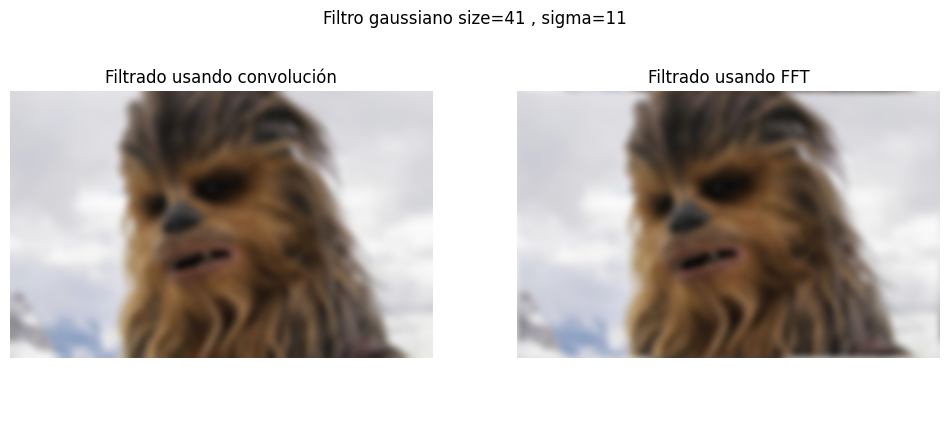

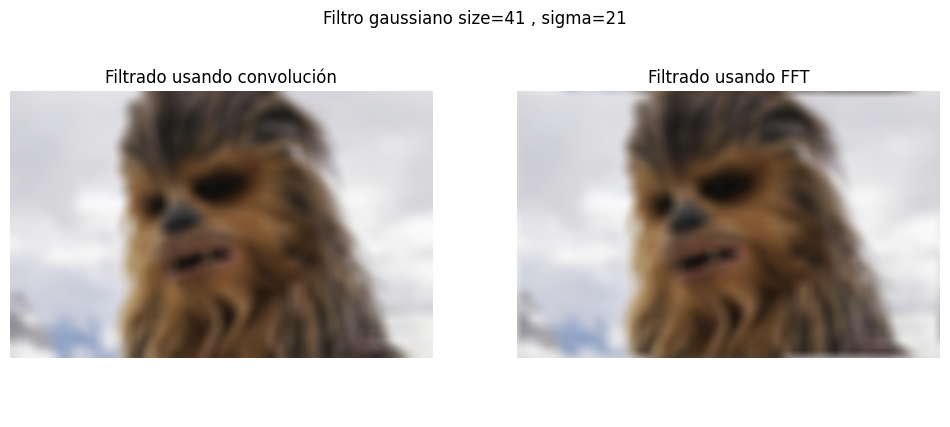

In [62]:
# Dejamos kernel fijo y probamos con diferentes sigmas
k_size = 41
sigmas = [0.1,9,11,21]

# Leo imagen con openCV
img_bgr = cv.imread('./chewbacca.jpg')

for sg in sigmas:
    # Creo kernel gaussiano con la función propia
    kernel, filter, kernel_tf = create_gauss_filter(img_orig.shape[1],img_orig.shape[0], k_size=k_size, sigma=sg)

    img_filtered_spatial =  cv.filter2D(img_bgr,  ddepth=-1, kernel=kernel)
    img_filtered_with_fft = filter_image_FFT(img_bgr,kernel_tf)
    
    imshow_compare(f"Filtro gaussiano size={k_size} , sigma={sg}","Filtrado usando convolución",img_filtered_spatial,"Filtrado usando FFT",img_filtered_with_fft)

## 2. Usando el método descripto en el paper Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.


In [11]:
#Implementacion del método descrito en el paper
def measure_fm(img):

    #1. FFT de la imagen
    F = np.fft.fft2(img)

    #2. Shift para llevar el origen al centro de la imagen
    Fc = np.fft.fftshift(F)
   
    #3. Calculo valor absoluto
    AF = np.abs(Fc)

    #4. Calculo componente frecuencial máxima
    M = np.max(AF)

    #5. Calculo valores por encima del threshold
    thres = M/1000
    Th = np.count_nonzero(np.where(F>thres,1,0))

    #6. Calculo calidad de la imagen
    FM = Th/(img.shape[0]*img.shape[1])

    return FM


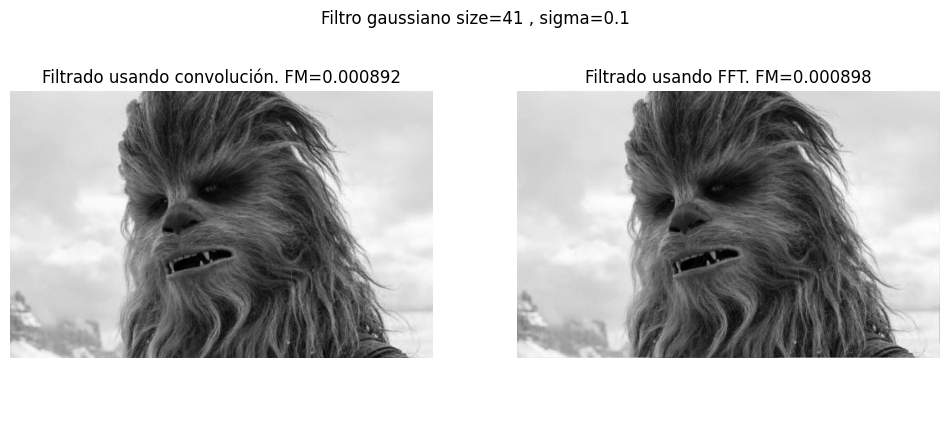

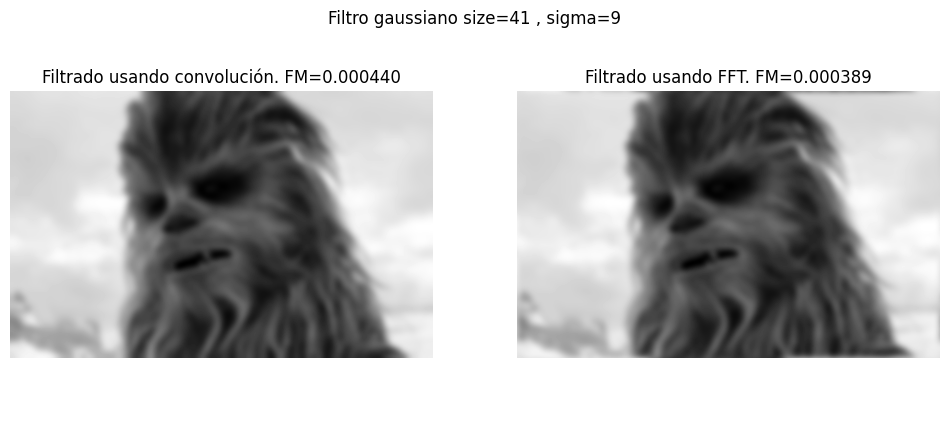

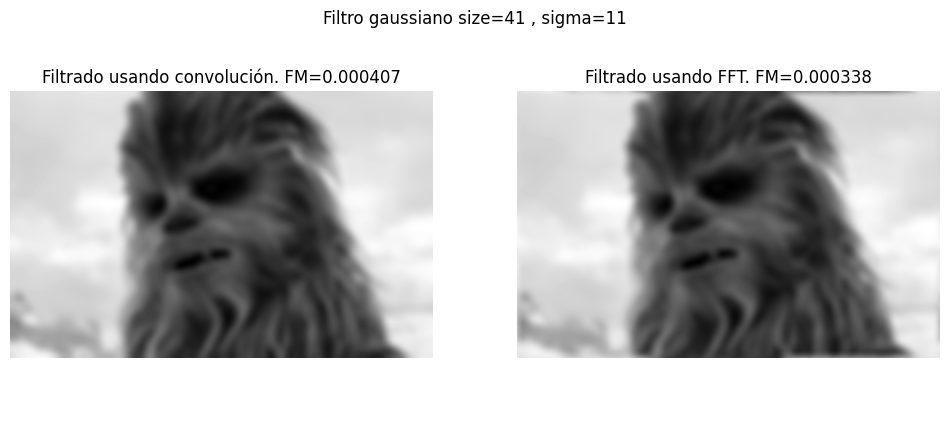

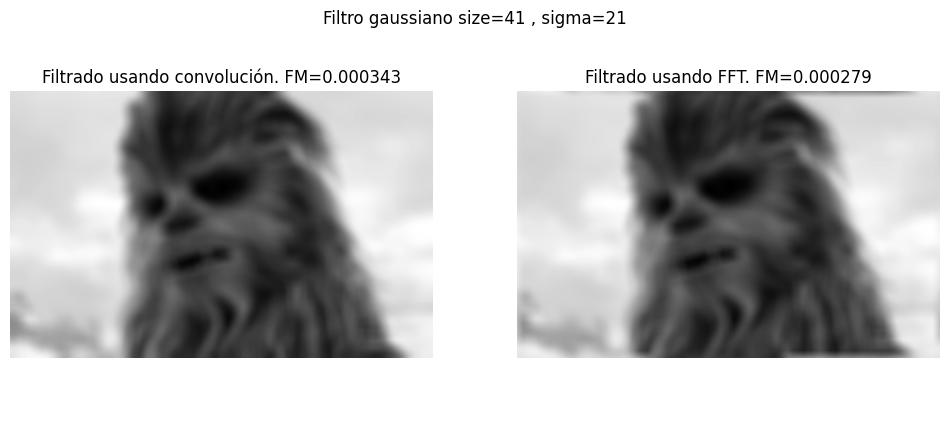

In [63]:
# Dejamos kernel fijo y probamos con diferentes sigmas
k_size = 41
sigmas = [0.1, 9,11,21]

# Leo imagen con openCV
img_gray = cv.imread('./chewbacca.jpg',cv.IMREAD_GRAYSCALE)

for sg in sigmas:
    # Creo kernel gaussiano con la función propia
    kernel, filter, kernel_tf = create_gauss_filter(img_gray.shape[1],img_gray.shape[0], k_size=k_size, sigma=sg)

    img_filtered_spatial =  cv.GaussianBlur(img_gray,ksize=(k_size,k_size),sigmaX=sg,sigmaY=sg)
    img_filtered_fft = 20*np.log((np.abs(np.fft.fftshift(np.fft.fft2(img_filtered_spatial)))))
    img_filtered_with_fft = filter_image_FFT(img_gray,kernel_tf,mode="gray")

    cv.imwrite(f"./img_blur/chewbacca_blur{sg}.jpg",img_filtered_spatial)
    cv.imwrite(f"./img_blur/chewbacca_blur{sg}_FFT.jpg",img_filtered_with_fft)
    
    imshow_compare(f"Filtro gaussiano size={k_size} , sigma={sg}",f"Filtrado usando convolución. FM={measure_fm(img_filtered_spatial):5f}",img_filtered_spatial,f"Filtrado usando FFT. FM={measure_fm(img_filtered_with_fft):5f}",img_filtered_with_fft,mode="gray")

Vemos nuevamente diferencias entre el filtrado espacial y con FFT, que a la vista parecen imperceptibles. Sin embargo, la métrica nos indica que las imágenes procesadas mediante el filtrado en el dominio frecuencial están más desenfocadas

## 3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape from focus”.

Del paper decidimos implementar el método WAV1 y WAV3:

In [47]:
def WAV3(image):
    
    # DWT de nivel 1 para obtener componente de frecuencias altas
    coeffs_1 = pywt.wavedec2(image, 'haar', level=1)
    cA1, (cH1, cV1, cD1) = coeffs_1

    # Calculo MH
    MH_squared = np.sum(np.square(cH1)) + np.sum(np.square(cV1)) + np.sum(np.square(cD1))

    # DWT de nivel 2 para obtener componente de frecuencias bajas
    coeffs_2 = pywt.wavedec2(image, 'haar', level=2)
    cA2, (cH3_1, cV3_1, cD3_1), (cH3_2, cV3_2, cD3_2) = coeffs_2
    
    # DWT de nivel 3 para obtener componente de frecuencias bajas
    coeffs_3 = pywt.wavedec2(image, 'haar', level=3)
    cA3, (cH3_1, cV3_1, cD3_1), (cH3_2, cV3_2, cD3_2), (cH3_3, cV3_3, cD3_3) = coeffs_3

    # Calculo ML
    # ML_squared = np.sum(np.square(cA1))+np.sum(np.square(cA2))+np.sum(np.square(cA3))
    ML_squared = np.sum(np.square(cA3))

    # Calculo ratio para obtener una medida del foco
    if ML_squared == 0:
        focus_measure = 0
    else:
        focus_measure = MH_squared / ML_squared
    
    return focus_measure

In [64]:
def WAV1(image):
    
    # DWT de nivel 1 para obtener componente de frecuencias altas
    coeffs_1 = pywt.wavedec2(image, 'db6', level=1)
    cA1, (cH1, cV1, cD1) = coeffs_1

    focus_measure =np.abs(cH1)+np.abs(cV1)+np.abs(cD1)
    
    return np.mean(focus_measure)

In [65]:
from scipy.ndimage import convolve

def laplacian_kernel(alpha=0.2):
    return np.array([[alpha, 1-alpha, alpha],
                     [1-alpha, -4, 1-alpha],
                     [alpha, 1-alpha, alpha]])

def LAP(image):
    # Defino kernel laplaciano
    laplacian_filter = laplacian_kernel()

    # Convoluciono con el filtro
    filtered_image = convolve(image, laplacian_filter, mode='reflect')

    # Calculo la media de la matriz filtrada al cuadrado
    focus_measure = np.mean(filtered_image**2)

    return focus_measure


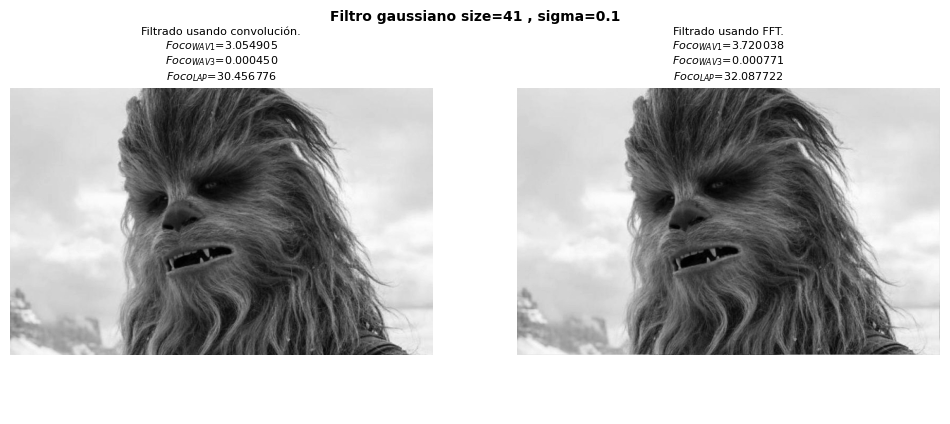

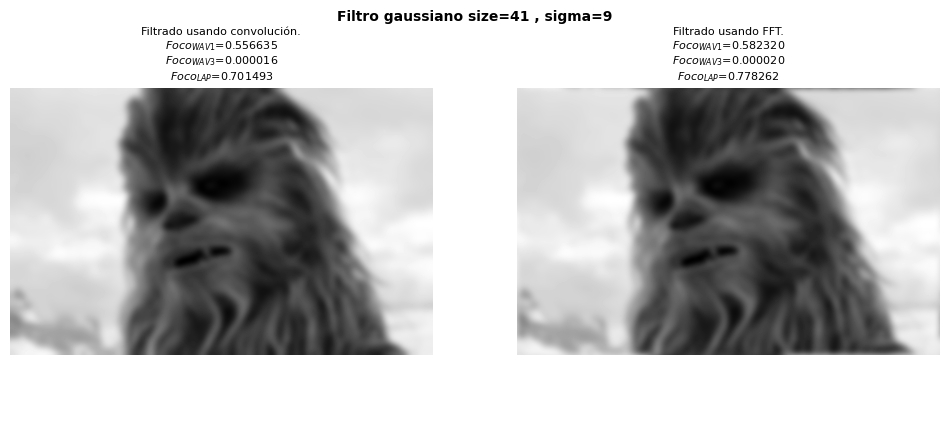

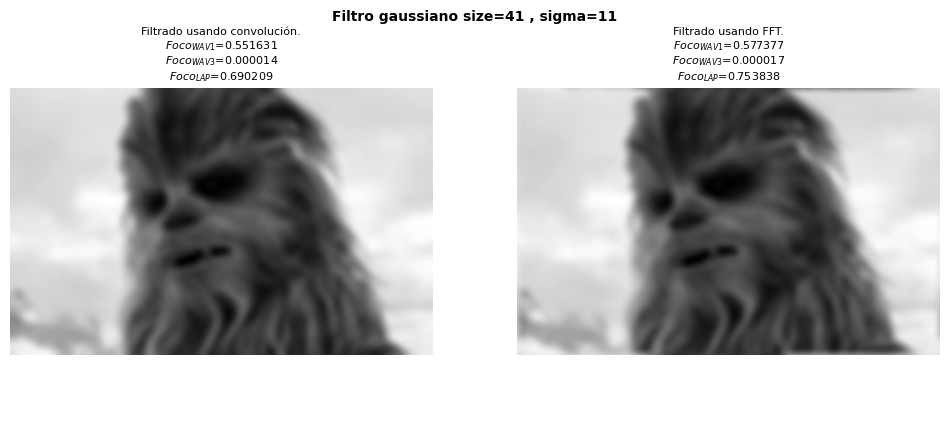

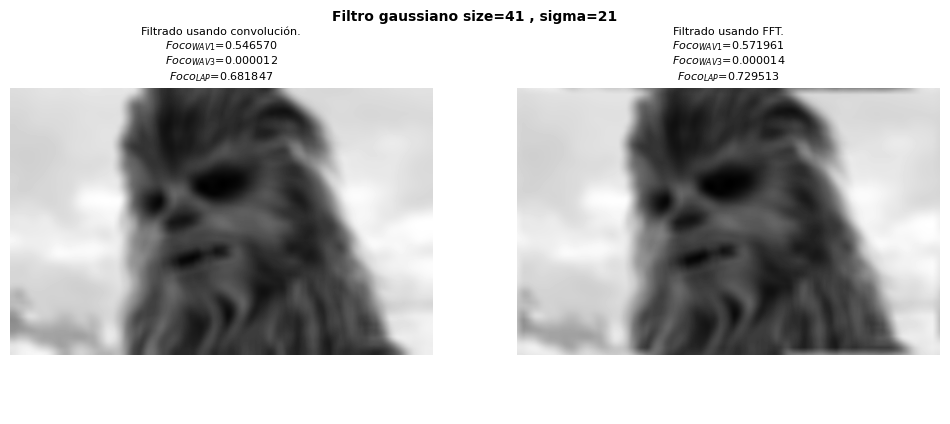

In [76]:
# Dejamos kernel fijo y probamos con diferentes sigmas
k_size = 41
sigmas = [0.1, 9,11,21]

# Leo imagen con openCV
img_gray = cv.imread('./chewbacca.jpg',cv.IMREAD_GRAYSCALE)

for sg in sigmas:
    # Creo kernel gaussiano con la función propia
    kernel, filter, kernel_tf = create_gauss_filter(img_gray.shape[1],img_gray.shape[0], k_size=k_size, sigma=sg)

    img_filtered_spatial =  cv.GaussianBlur(img_gray,ksize=(k_size,k_size),sigmaX=sg,sigmaY=sg)
    img_filtered_fft = 20*np.log((np.abs(np.fft.fftshift(np.fft.fft2(img_filtered_spatial)))))
    img_filtered_with_fft = filter_image_FFT(img_gray,kernel_tf,mode="gray")
    
    resultados_con_convolucion = f"$Foco_{{WAV1}}$={WAV1(img_filtered_spatial):7f}\n"
    resultados_con_convolucion += f"$Foco_{{WAV3}}$={WAV3(img_filtered_spatial):7f}\n"
    resultados_con_convolucion += f"$Foco_{{LAP}}$={LAP(img_filtered_spatial):7f}"

    resultados_con_fft = f"$Foco_{{WAV1}}$={WAV1(img_filtered_with_fft):7f}\n"
    resultados_con_fft += f"$Foco_{{WAV3}}$={WAV3(img_filtered_with_fft):7f}\n"
    resultados_con_fft += f"$Foco_{{LAP}}$={LAP(img_filtered_with_fft):7f}"

    imshow_compare(f"Filtro gaussiano size={k_size} , sigma={sg}",f"Filtrado usando convolución.\n{resultados_con_convolucion}",img_filtered_spatial,f"Filtrado usando FFT.\n{resultados_con_fft}",img_filtered_with_fft,mode="gray")

## Conclusión

[- Será llenada luego de entender las diferencias entre punto 2 y 3 -]